# EE5175 Lab 6 : Shape from Focus
Author: Kishore Rajendran [EE20B064]

Date: 18 March 2024

In [227]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io

Reference: Shape From Focus (Shree Nayar, CVPR'92) https://graphics.stanford.edu/courses/cs348b-06/homework3/Nayar_CVPR92.pdf

#### Analyzing the given stack of images

Loading the stack of images given as a .mat file into a dictionary using the $\texttt{scipy.io}$ library

We can see that the stack contains 100 images each of size (115, 115)

In [228]:
# Loading the .mat file into a dictionary
stack = scipy.io.loadmat('stack.mat')
print("Number of images in the stack = ", stack['numframes'])
print("Image size = ", stack['frame001'].shape)

numframes = stack['numframes'][0, 0]
img_stack = {}
counter  = 1

# Extracting all the images and storing it in img_stack
for key in stack.keys():
    if key[:5] == 'frame':
        img_stack[counter] = stack[key]
        counter+=1

Number of images in the stack =  [[100]]
Image size =  (115, 115)


#### Sum Modified Laplacian (SML) Operator
SML is an operator used to obtain the focus measure and is defined as the sum of modified laplacian values in a small $q$ x $q$ window around that 
$$
SML(x, y) = \sum_{x=i-q}^{i+q}\sum_{y=j-q}^{j+q} ML (x, y)
$$

where the Modified Laplacian operator is defined as:
$$
ML(x, y) = |I(x-1, y) + I(x+1, y) - 2I(x,y)| + |I(x, y-1) + I(x, y+1) - 2I(x,y)|
$$

which can be obtained by multiplying each 3x3 window of the image with the kernels:

$$
gradx = 
\begin{bmatrix}
0 & 0 & 0\\ 
1 & -2 & 1\\ 
0 & 0 & 0
\end{bmatrix},

\quad

grady = 
\begin{bmatrix}
0 & 1 & 0\\ 
0 & -2 & 0\\ 
0 & 1 & 0
\end{bmatrix}
$$

In [229]:
# Defining the kernels required to calculate fxx and fyy
gradx = np.array([[0,  0, 0], 
                  [1, -2, 1], 
                  [0,  0, 0]])
grady = np.array([[0,  1, 0], 
                  [0, -2, 0], 
                  [0,  1, 0]])

# Applying the discretized Modified Laplacian for all points in the image
def ML(img):
    # Pad the image
    pad_size = 1
    pad_img = np.pad(img, ((pad_size,pad_size), (pad_size,pad_size)), mode='constant', constant_values=(0,0))
    ml_img = np.zeros_like(pad_img, dtype=float)
    # Multiply with the defined kernels to get the ml measure
    for x in range(pad_size, img.shape[0]+pad_size):
        for y in range(pad_size, img.shape[1]+pad_size):
            fxx = np.sum(gradx*pad_img[x-1:x+2, y-1:y+2])
            fyy = np.sum(grady*pad_img[x-1:x+2, y-1:y+2])
            ml_img[x, y] = np.abs(fxx) + np.abs(fyy)
    # Remove the padding from the resulting image
    ml_img = ml_img[pad_size:-pad_size, pad_size:-pad_size]
    return ml_img

In [230]:
# Using the Modified Laplacian for all points in the image to calculate the Sum Modified Laplacian
def SML(img, q):
    # First find the modified laplacian measures for all the points
    ml_img = ML(img)
    if q==0:
        return ml_img
    # Pad the modified laplacian matrix
    pad_size = q
    pad_ml_img = np.pad(ml_img, ((pad_size,pad_size), (pad_size,pad_size)), mode='constant', constant_values=(0,0))
    # Calculating SML for all points in the image
    sml_img = np.zeros_like(pad_ml_img, dtype=float)
    for x in range(pad_size, ml_img.shape[0]+pad_size):
        for y in range(pad_size, ml_img.shape[1]+pad_size):
            # Summing the neighbouring q^2 elements
            sml_img[x, y] = np.sum(pad_ml_img[x-q:x+q+1, y-q:y+q+1])
    # Remove the padding from the resulting image
    sml_img = sml_img[pad_size:-pad_size, pad_size:-pad_size]
    return sml_img

Apply this on all images of the given stack to obtain focus measures at all points in all the images ie: A stack of focus measures

In [231]:
def calculate_sml_focus_measure(img_stack, q, numframes):
    x,y = img_stack[1].shape
    fm_stack = np.zeros((x, y, numframes+1))
    for i in img_stack.keys():
        fm_stack[:, :, i] = SML(img_stack[i], q)
    return fm_stack

#### Depth Estimation
Using Gaussian Interpolation about the peak region of the focus measure values, we obtain accurate depth estimates

Upon solving the gaussian interpolation equations, we get:
$$
\bar{d} = \frac{(ln(F_m) - ln(F_{m-1}))(d_m^2 - d_{m-1}^2) - (ln(F_m) - ln(F_{m+1}))(d_m^2 - d_{m+1}^2)}{2\Delta d (2ln(F_m) - ln(F_{m+1}) - ln(F_{m-1}))}
$$
where $d_m$ = $m\Delta d$ 

In [232]:
def depth_estimate(m, fm_stack, del_d, x, y):
    if fm_stack[x, y, m] == 0 or fm_stack[x, y, m-1] == 0 or fm_stack[x, y, m+1] == 0:
        return m*del_d
    logFm = np.log(fm_stack[x, y, m])
    logFm_prev = np.log(fm_stack[x, y, m-1])
    logFm_next = np.log(fm_stack[x, y, m+1])
    nr = (((logFm - logFm_prev)*(2*m+1)) - ((logFm - logFm_next)*(-2*m+1)))*(del_d**2)
    dr = 2*del_d*(2*logFm - logFm_next - logFm_prev)
    dbar = nr/dr 
    return dbar

Calculating the depth estimates for all points in the image stack using above defined functions

In [233]:
def estimate_depth_map(img_stack, q, del_d):
    # Obtaining the focus measure stack
    fm_stack = calculate_sml_focus_measure(img_stack, q, numframes)
    # Finding the m corresponding to maximum value of SML focus measure for each pixel
    max_m = np.argmax(fm_stack, axis=2)
    depths = np.zeros_like(max_m, dtype=float)
    for x in range(fm_stack.shape[0]):
        for y in range(fm_stack.shape[1]):
            # If maximum occurs at the first or last images
            if max_m[x, y] == 0 or max_m[x, y] == numframes:
                depths[x, y] = del_d*max_m[x, y]
            else:
                depths[x, y] = depth_estimate(max_m[x, y], fm_stack, del_d, x, y)
    return depths

Function to plot the 3D depth maps

In [234]:
def plot_3d_depth_map(depth_map, q):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    X, Y = np.meshgrid(np.arange(depth_map.shape[0]), np.arange(depth_map.shape[1]))
    map = ax.plot_surface(X, Y, depth_map, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')

    fig.colorbar(map, shrink=0.5, aspect=5)
    ax.set_title(f'Depth map for q = {q}')

Calling the functions for q = 0, 1, 2

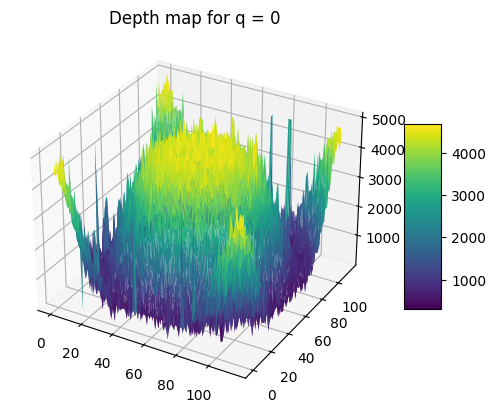

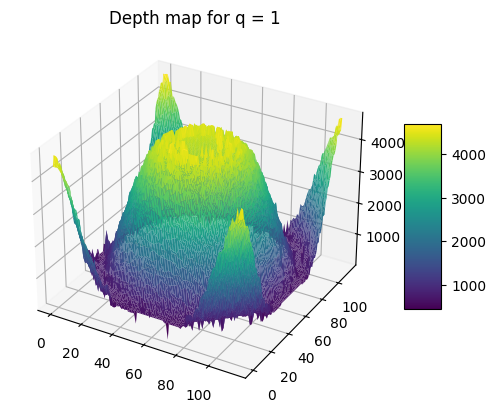

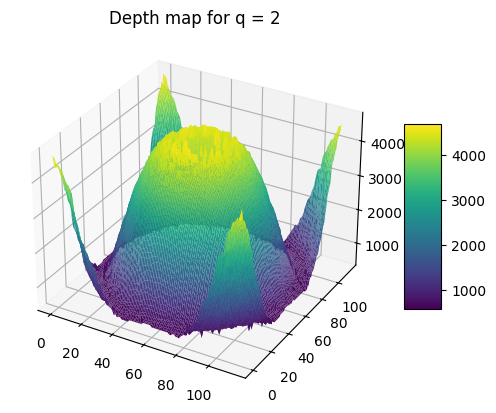

In [235]:
del_d = 50.50
d0_map = estimate_depth_map(img_stack, 0, del_d)
d1_map = estimate_depth_map(img_stack, 1, del_d)
d2_map = estimate_depth_map(img_stack, 2, del_d)

plot_3d_depth_map(d0_map, 0)
plot_3d_depth_map(d1_map, 1)
plot_3d_depth_map(d2_map, 2)

# Observations
1. As the value of q increases, the depth map obtained becomes smoother, and perhaps a better estimate of the actual depths.
2. The depth estimates at the boundary of our image cannot be entirely trusted since the focus measures at these corner points has been obtained by padding the image with zeros. Thus we can ignore the sudden increase in depth at the 4 corners in the observed plots.
3. Although the SFF method is mainly used for obtaining depth variation in small objects where standard methods like stereo fail, do note that the variation should be enough to show changes in intensity as the depth changes.This is termed as being 'visibly rough' in the paper.